In [1]:
import proplot as plot
import numpy as np
import yaml
import glob
import seaborn as sns

%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import logging
import sys

import pizza_cutter

logging.basicConfig(stream=sys.stdout)
for code in ["ngmix", "metadetect", "pizza_cutter", "pizza_cutter_sims"]:
    logging.getLogger(code).setLevel(
        getattr(logging, "DEBUG"))

In [8]:
import tempfile
from pizza_cutter_sims.pizza_cutter import run_des_pizza_cutter_coadding_on_sim
from pizza_cutter_sims.sim import generate_sim
from pizza_cutter_sims.constants import PIXEL_SCALE
from pizza_cutter_sims.mdet import run_metadetect

cfg_yaml = """\
shear:
  scene: True

  # these keys are used to build paired sims w/ noise cancellation
  g: 0.02
  swap12: False

  # set these to run a sim directly
  g1: 0.02
  g2: 0.00

msk:
  cosmic_rays: True
  bad_columns: True
  streaks:
    mean_streaks: 0.3
    # min_width: 2
    # max_width: 10
  

coadd:
  central_size: 225
  buffer_size: 25
  scale: 0.263

se:
  n_images: 1
  wcs_config:
    position_angle_range: [0, 360]
    dither_scale: 1  # set to an odd number of pixels
    scale: 0.263
    scale_frac_std: 0.01
    shear_std: 0.01

psf:
  type: wldeblend
  fwhm_frac_std: 0.1
  shear_std: 0.1
  shear: [0, 0]

layout:
  type: hex
  ngal_per_side: 10
  ngal_per_arcmin2: 60
  dither_scale: 0.263

gal:
  type: lsst-riz

star:
  dens_factor: 5
  rad_dist: uniform
  interp:
    skip: True
    # these control how the interpolation is applied for star holes
    # if fill_isolated_with_noise is True, then any missing pixel with no non-missing
    # pixels within iso_buff will be filled with noise and then used to interpolate
    # the rest of the pixels.
    iso_buff: 1
    fill_isolated_with_noise: False
  apodize:
    skip: False
    ap_rad: 1
  mask_expand_rad: 16

pizza_cutter:
  skip: False
  single_epoch_config:
    # pixel spacing for building various WCS interpolants
    se_wcs_interp_delta: 10
    coadd_wcs_interp_delta: 25
    frac_buffer: 1.42  # buffer around SE image to account for position angle rotations

    reject_outliers: False
    symmetrize_masking: True
    copy_masked_edges: False
    max_masked_fraction: 1.1
    edge_buffer: 8
    mask_tape_bumps: False

    # set the interp flags to 0 or 3 or 7 to interp stuff in the mask
    spline_interp_flags:
      - 7
    noise_interp_flags:
      - 0

    # always zero
    bad_image_flags:
      - 0

metadetect:
  metacal:
    psf: fitgauss
    types: [noshear, 1p, 1m, 2p, 2m]
    use_noise_image: True

  psf:
    lm_pars:
      maxfev: 2000
      ftol: 1.0e-05
      xtol: 1.0e-05
    model: gauss

    # we try many times because if this fails we get no psf info
    # for the entire patch
    ntry: 10

  sx:

  weight:
    fwhm: 1.2  # arcsec

  meds:
    box_padding: 2
    box_type: iso_radius
    max_box_size: 64
    min_box_size: 32
    rad_fac: 2
    rad_min: 4

  maskflags: 33554432  # 2**25 = BMASK_GAIA_STAR from pizza cutter

  # check for an edge hit
  bmask_flags: 1610612736  # 2**29 || 2**30
"""

cfg = yaml.safe_load(cfg_yaml)

In [10]:
import tqdm

for _ in tqdm.trange(1):
    seeds = np.random.randint(low=1, high=2**29, size=5)
    rng = np.random.RandomState(seed=seeds[0])
    gal_rng = np.random.RandomState(seed=seeds[1])
    coadd_rng = np.random.RandomState(seed=seeds[2])
    mdet_rng = np.random.RandomState(seed=seeds[3])
    star_rng = np.random.RandomState(seed=seeds[4])

    data = generate_sim(
        rng=rng,
        gal_rng=gal_rng,
        coadd_config=cfg["coadd"],
        se_config=cfg["se"],
        psf_config=cfg["psf"],
        gal_config=cfg["gal"],
        layout_config=cfg["layout"],
        msk_config=cfg["msk"],
        shear_config=cfg["shear"],
        star_rng=star_rng,
        skip_coadding=False,
        star_config=cfg["star"],        
    )

    with tempfile.TemporaryDirectory() as tmpdir:
        cdata = run_des_pizza_cutter_coadding_on_sim(
            rng=coadd_rng,
            tmpdir=tmpdir,
            single_epoch_config=cfg["pizza_cutter"]["single_epoch_config"],
            img=data["img"],
            wgt=data["wgt"],
            msk=data["msk"],
            bkg=data["bkg"],
            info=data["info"],
            n_extra_noise_images=0,
        )

#     res = run_metadetect(
#         rng=mdet_rng,
#         config=cfg["metadetect"],
#         wcs=data["info"]["affine_wcs"],
#         image=cdata["image"],
#         bmask=cdata["bmask"],
#         ormask=cdata["ormask"],
#         noise=cdata["noise"],
#         psf=cdata["psf"],
#         weight=cdata["weight"],
#         mfrac=cdata["mfrac"],
#     )


  0%|                                                                                                                                               | 0/1 [00:00<?, ?it/s]

DEBUG:pizza_cutter_sims.wcs:generated wcs: galsim.AffineTransform(0.2680977411044161, 0.008922700839092515, -0.011329308056076307, 0.25459786925894623, origin=galsim.PositionD(x=239.20912927175848, y=239.24976195016924), world_origin=galsim.PositionD(x=0.0, y=0.0))
DEBUG:pizza_cutter_sims.psf:wldeblend psf config: {'type': 'Kolmogorov', 'fwhm': 1.1623742846457887, 'shear': {'type': 'G1G2', 'g1': 0.05515978742356292, 'g2': 0.10478269169940535}}
DEBUG:pizza_cutter_sims.psf:wldeblend galsim psf: galsim.Kolmogorov(lam_over_r0=1.1911239309017874).shear(galsim.Shear(g1=0.05515978742356299,g2=0.10478269169940534))
DEBUG:pizza_cutter_sims.stars:generating 5 stars
INFO:pizza_cutter.des_pizza_cutter._load_info:loading image data products for coadd/coadd
INFO:pizza_cutter.des_pizza_cutter._load_info:loading image data products for epoch0/epoch0
INFO:pizza_cutter.des_pizza_cutter._coadd_slices:generating slice objects for ra,dec = 0.0|0.0
DEBUG:pizza_cutter.des_pizza_cutter._coadd_slices:found pos

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:13<00:00, 13.59s/it]


In [11]:
print(seeds)

[512126771 248014061 510522798 485733466   6411217]


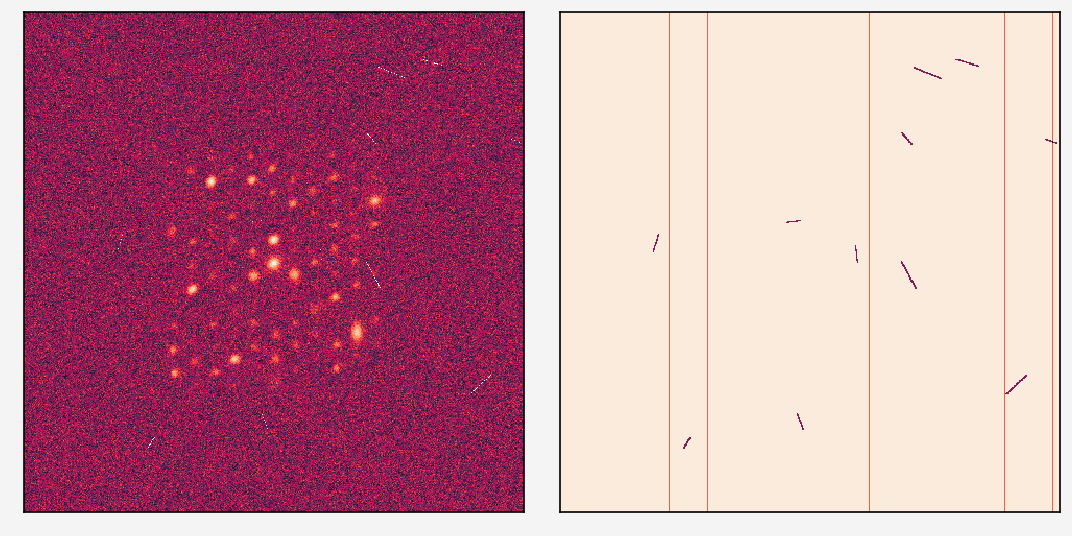

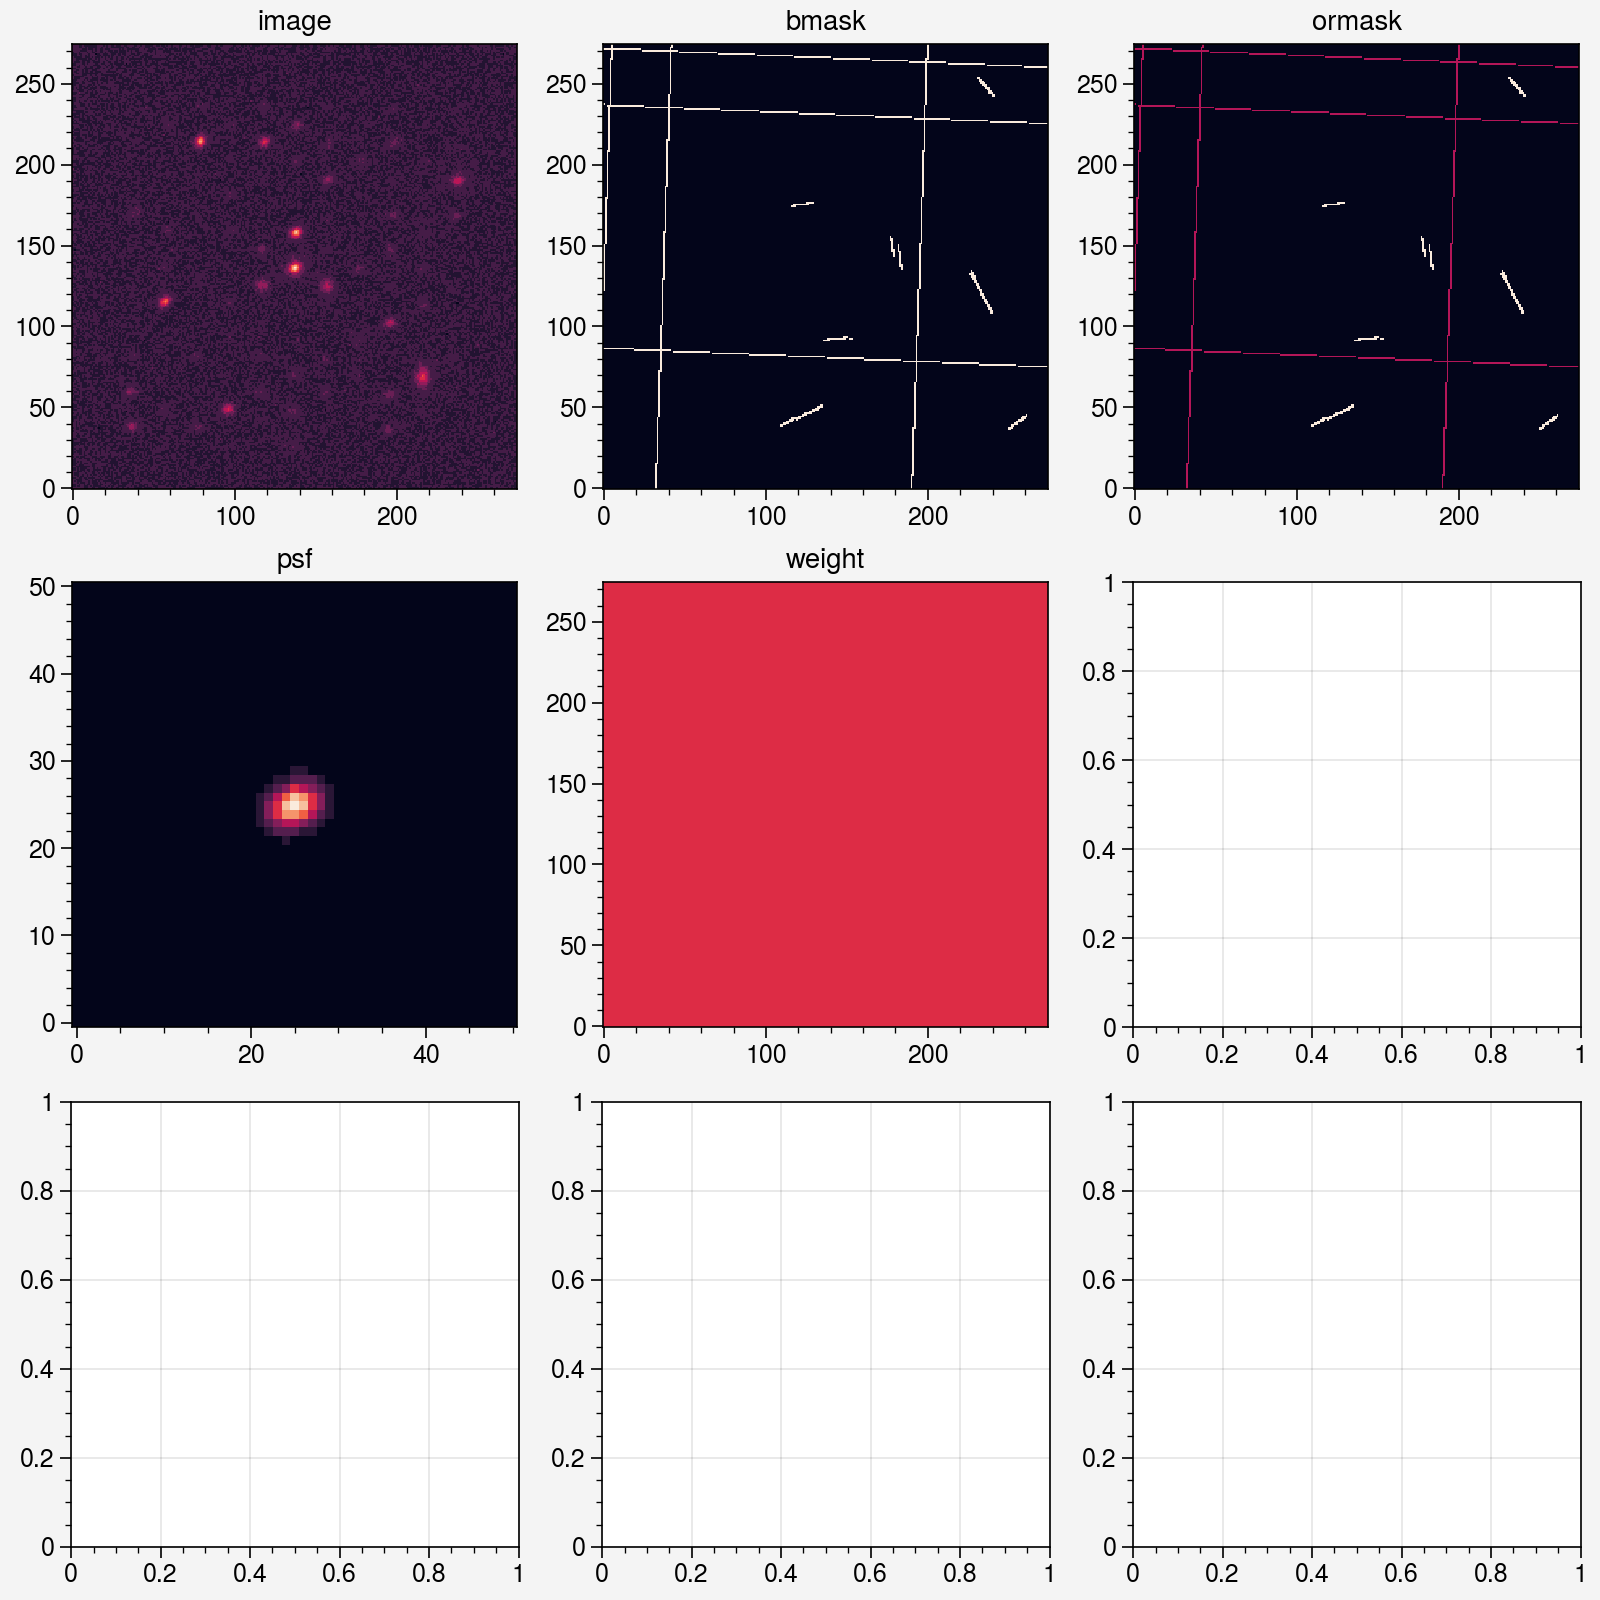

In [13]:
fig, axs = plot.subplots(nrows=len(data["img"]), ncols=2)

for i in range(len(data["img"])):
    axs[i, 0].pcolormesh(np.arcsinh(data["img"][i]*np.sqrt(data["wgt"][i])), cmap="rocket")
    axs[i, 0].set_aspect(1)
    axs[i, 0].xaxis.set_visible(False)
    axs[i, 0].yaxis.set_visible(False)
    axs[i, 1].pcolormesh(data["msk"][i], cmap="rocket_r")
    axs[i, 1].set_aspect(1)
    axs[i, 1].xaxis.set_visible(False)
    axs[i, 1].yaxis.set_visible(False)
    
fig, axs = plot.subplots(nrows=3, ncols=3, figsize=(8, 8), share=0)

for i, key in enumerate(["image", "bmask", "ormask", "psf", "weight"]):
    axs[i].pcolormesh(cdata[key], cmap="rocket")
    axs[i].set_aspect(1)
    axs[i].set_title(key)
# for i in range(4, 8):
#     axs[i].pcolormesh(cdata["extra_noises"][i-4], cmap="rocket")
#     axs[i].set_aspect(1)
#     axs[i].set_title(key)
    

NameError: name 'res' is not defined

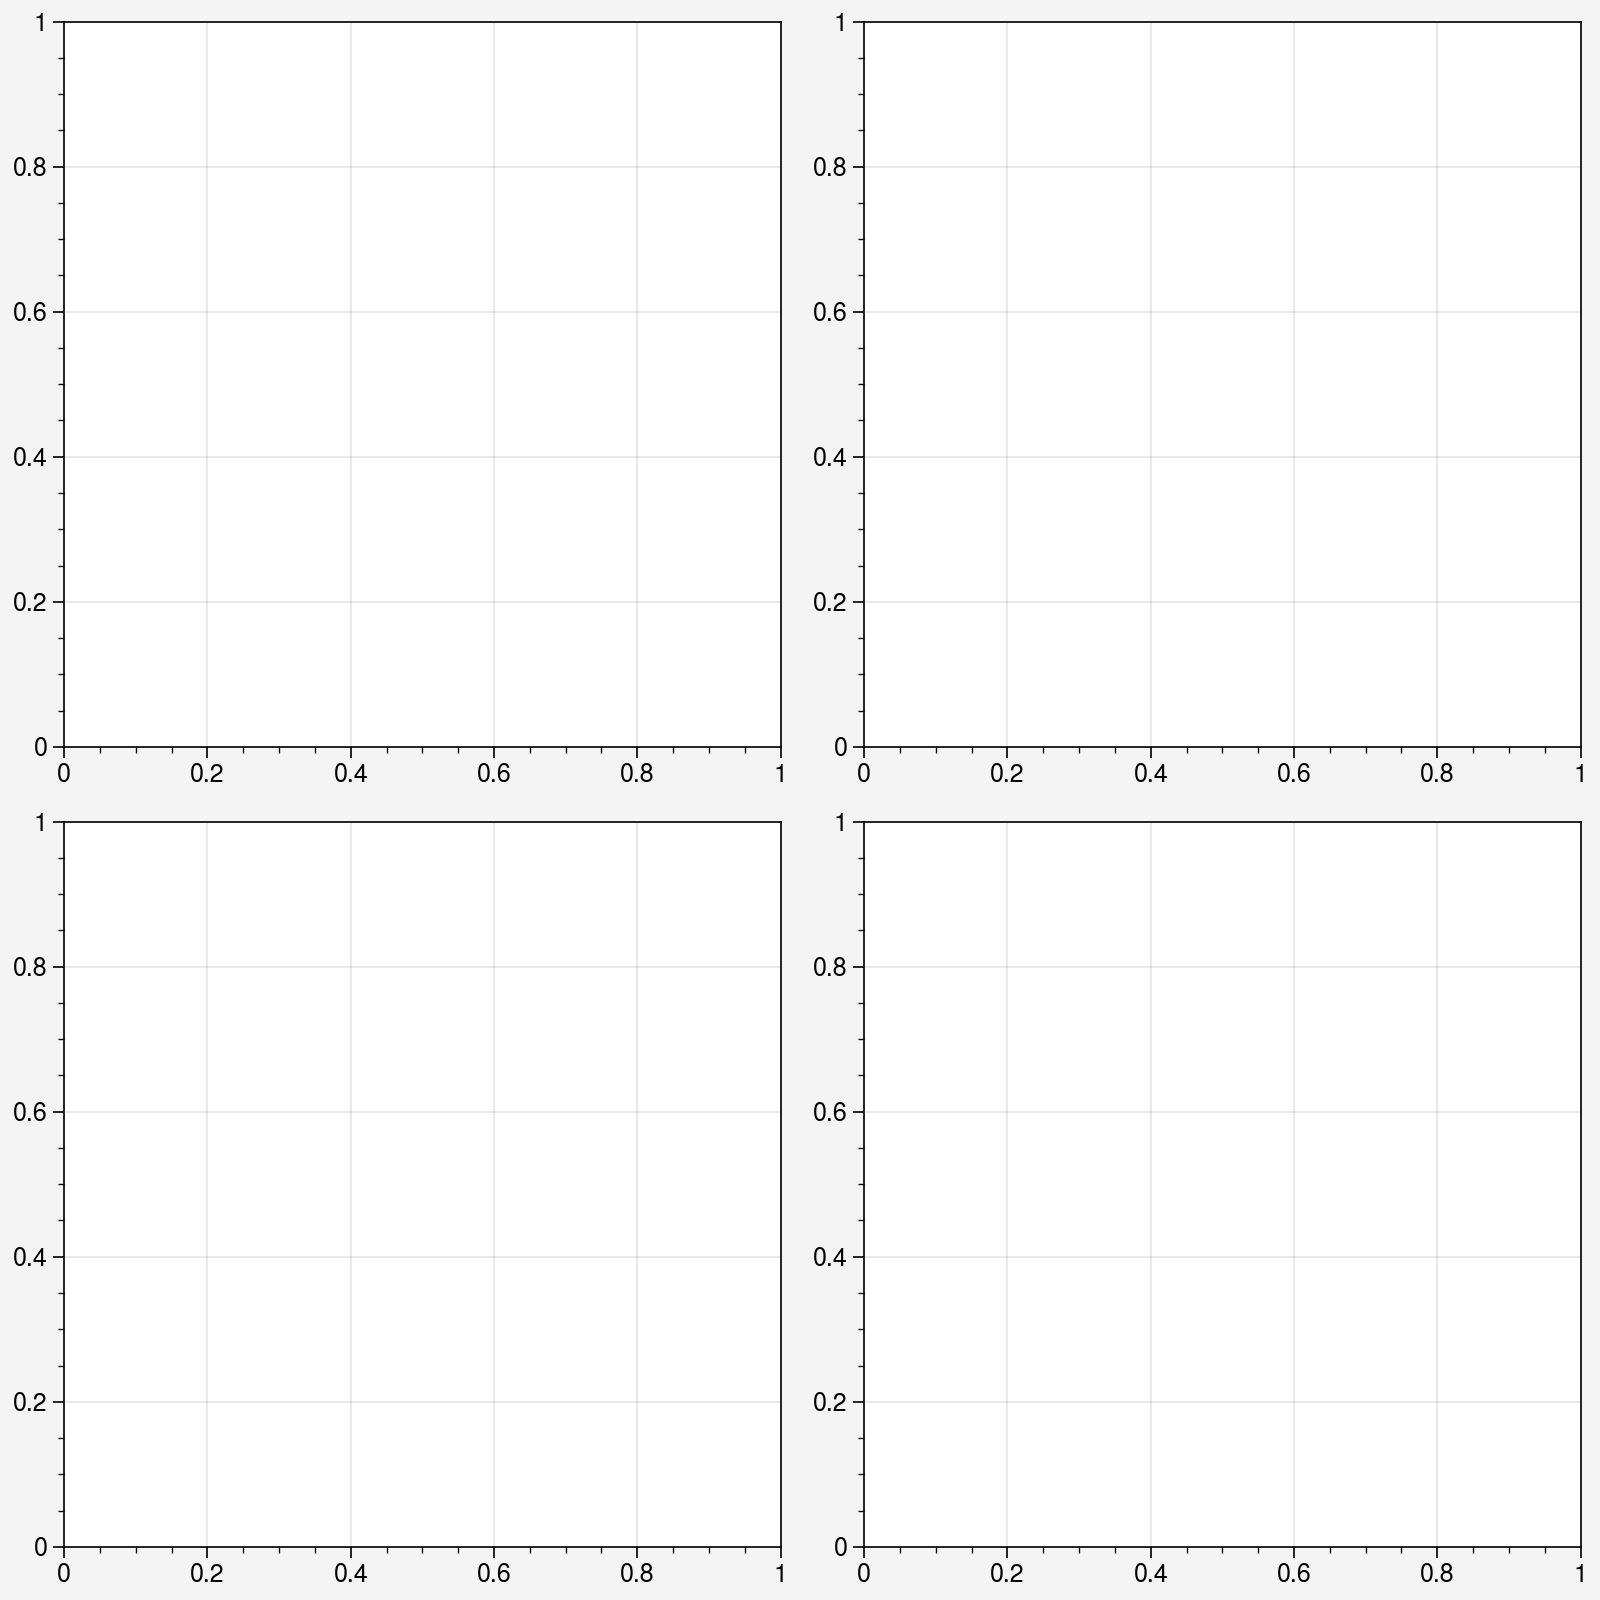

In [14]:
from scipy.interpolate import griddata

fig, axs = plot.subplots(nrows=2, ncols=2, figsize=(8, 8), share=0)

msk = res["noshear"]["ormask"] != 0
mmsk = res["noshear"]["mfrac"] > 0.1

axs[0, 0].pcolormesh(np.arcsinh(cdata["image"]* np.sqrt(cdata["weight"])), cmap="rocket")
axs[0, 0].plot(res["noshear"]["sx_col"], res["noshear"]["sx_row"], ".", color="blue")
axs[0, 0].plot(res["noshear"]["sx_col"][msk], res["noshear"]["sx_row"][msk], "o", color="orange")
axs[0, 0].plot(res["noshear"]["sx_col"][mmsk], res["noshear"]["sx_row"][mmsk], ".", color="yellow")
axs[0, 0].set_xlim(0, cdata["image"].shape[0])
axs[0, 1].pcolormesh(cdata["ormask"], cmap="rocket")

xyvals = np.linspace(0, cdata["image"].shape[0], 50)
gx, gy = np.meshgrid(xyvals, xyvals)
gx = gx.ravel()
gy = gy.ravel()
zvals = griddata(
    np.array([
        res["noshear"]["sx_col"], 
        res["noshear"]["sx_row"], 
    ]).T,
    res["noshear"]["mfrac"],
    np.array([gx, gy]).T,
    fill_value=0,
).reshape(xyvals.shape[0], xyvals.shape[0])

axs[1, 0].pcolormesh(xyvals, xyvals, zvals, cmap='rocket', vmin=0, vmax=1)
axs[1, 0].set_xlim(0, cdata["image"].shape[0])
axs[1, 0].set_ylim(0, cdata["image"].shape[0])

sns.kdeplot(res["noshear"]["mfrac"], ax=axs[1, 1], cut=0, bw_adjust=0.1)
axs[1, 1].set_xlabel("masked fraction")